# Test models performences

2025-06-11 23:03:10.788330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749672190.797358  138131 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749672190.800017  138131 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749672190.806706  138131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749672190.806718  138131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749672190.806719  138131 computation_placer.cc:177] computation placer alr

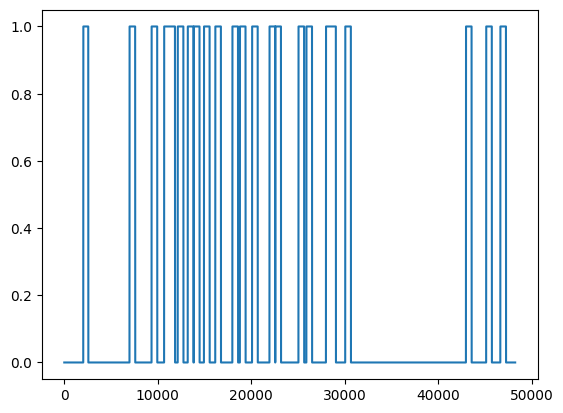

In [1]:
# import modules and load data
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load input and output data
X = np.load("../data/processed/input.npy")
Y = np.load("../data/processed/output.npy")

# TODO: Custom shuffle for RNN model
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(X, Y, test_size=0.1, shuffle=False)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_train_s, y_train_s, test_size=0.1, shuffle=False)

plt.plot(range(len(y_val_s)), y_val_s)
plt.show()

#### Model 1

In [ ]:
from sklearn.utils import class_weight
from model import create_sequences

# Number of frames fed into the LSTM layer at one time
sequence_length = 30 * 3  # fps * seconds

# The max number of neurons in the LSTM/RNN layer (min 16)
max_layer_neurons = 1024

# FIX IT
# Reshape the data from (n, 14) to (n, sequence_length, 14)
x_train, y_train = create_sequences(x_train_s, y_train_s, sequence_length)
x_val, y_val = create_sequences(x_val_s, y_val_s, sequence_length)
x_test, y_test = create_sequences(x_test_s, y_test_s, sequence_length)

# Adapt the normlizer layer to the feature axis in the input data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(x_train)

# Define the model 
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(sequence_length,14)),
    normalizer,
    # layers.SimpleRNN(1024, input_shape=(1,14) ,return_sequences=False),  # or use LSTM/GRU
    layers.LSTM(max_layer_neurons, input_shape=(sequence_length,14), recurrent_dropout=0.5),
    layers.Dense(max_layer_neurons//2, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(max_layer_neurons//4, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(max_layer_neurons//8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Output a single scalar
])

# Add more metrices!
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Penalize the model more for misclassifying the minority class using class weight
# Calculate the class weights
weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))

print("Calculated Class Weights:", class_weights)

# Train model (20 epochs atleast)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=64, class_weight=class_weights)


I0000 00:00:1749672192.835981  138131 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/ubu/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/ubu/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Calculated Class Weights: {np.float64(0.0): np.float64(0.6944501738988186), np.float64(1.0): np.float64(1.7856764022750964)}
Epoch 1/2
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 631s 103ms/step - accuracy: 0.7484 - loss: 0.5281 - val_accuracy: 0.5044 - val_loss: 0.8739
Epoch 2/2
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 630s 103ms/step - accuracy: 0.7870 - loss: 0.4323 - val_accuracy: 0.4291 - val_loss: 0.7886


## Test Performences

==== MODEL #1 ====
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step
Probability Plot:


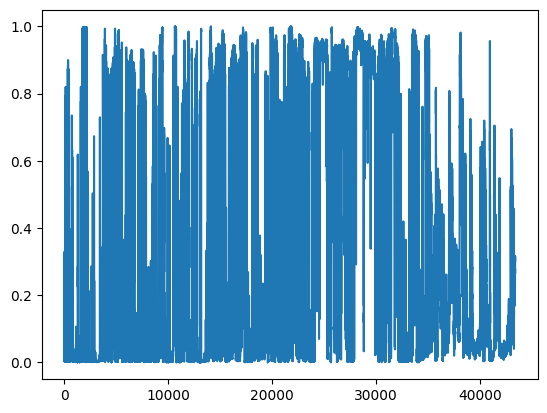

Predition/Test Plot:


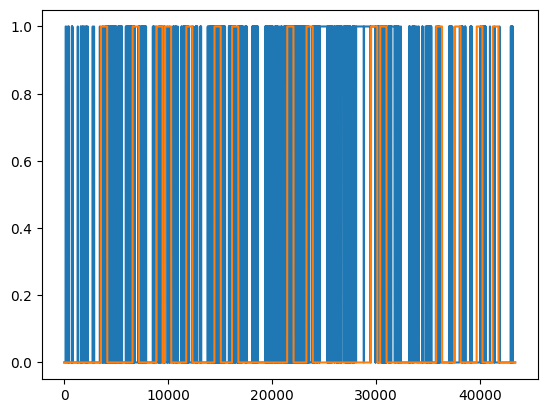

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.68      0.73     34526
         1.0       0.18      0.28      0.22      8844

    accuracy                           0.60     43370
   macro avg       0.49      0.48      0.48     43370
weighted avg       0.66      0.60      0.63     43370



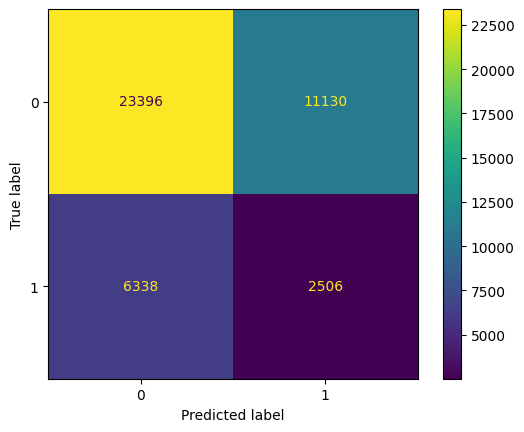

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')

# Model 1
print("==== MODEL #1 ====")

# Predict probabilities
y1_prob = model.predict(x_test)

# Convert probabilities to binary predictions (> 50% for positive prediction)
y1_pred = (y1_prob >= 0.5).astype(int).squeeze() 

# Confusion Matrix
cm1 = confusion_matrix(y_test, y1_pred)
disp1 = ConfusionMatrixDisplay(cm1)

print("Probability Plot:")
plt.plot(range(len(y1_prob)), y1_prob)
plt.show()

print("Predition/Test Plot:")
plt.plot(range(len(y1_pred)), y1_pred, y_test)
plt.show()

# Classification Report
report1 = classification_report(y_test, y1_pred)

disp1.plot()
print("Classification Report:\n", report1)


Best F1-Score for Class 1: 0.3145
Found at threshold: 0.05


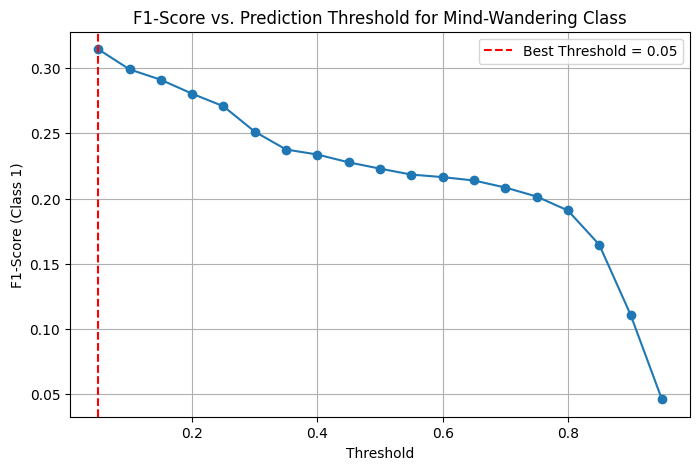

\n==== Classification Report with Optimal Threshold ====\n
              precision    recall  f1-score   support

         0.0       0.81      0.42      0.56     34526
         1.0       0.21      0.61      0.31      8844

    accuracy                           0.46     43370
   macro avg       0.51      0.51      0.43     43370
weighted avg       0.69      0.46      0.51     43370



In [4]:
# optimization tests

from sklearn.metrics import f1_score, precision_score, recall_score

# Use the probabilities predicted by the model on the test set
y_prob = y1_prob 

# Test thresholds from 0.05 to 0.95
thresholds = np.arange(0.05, 1.0, 0.05)
f1_scores = []

for thresh in thresholds:
    # Get predictions for the current threshold
    y_pred_temp = (y_prob >= thresh).astype(int).squeeze()
    
    # Calculate F1 score for the 'mind wandering' class (pos_label=1)
    f1 = f1_score(y_test, y_pred_temp, pos_label=1)
    f1_scores.append(f1)

# Find the best threshold
best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print(f"Best F1-Score for Class 1: {best_f1:.4f}")
print(f"Found at threshold: {best_threshold:.2f}")

# Plot the F1 scores vs thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1-Score vs. Prediction Threshold for Mind-Wandering Class')
plt.xlabel('Threshold')
plt.ylabel('F1-Score (Class 1)')
plt.grid(True)
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.legend()
plt.show()

# Now, let's see the full classification report with the best threshold
print("\\n==== Classification Report with Optimal Threshold ====\\n")
y_pred_best = (y_prob >= best_threshold).astype(int).squeeze()
report_best = classification_report(y_test, y_pred_best)
print(report_best)